In [4]:
import numpy as np
import pandas as pd
import geopandas as gp
import requests
import seaborn as sns

In [5]:
# test requests module
payload = {'key1': 'value1', 'key2': 'value2'}

r = requests.get('http://httpbin.org/get', params=payload)
print r.url

http://httpbin.org/get?key2=value2&key1=value1


### Get census tract centroids for approximate study area

In [6]:
# read census tract geojson (source: )
ct = gp.read_file('2010 Census Tracts.geojson')
ct.head()

,boro_code,boro_ct_2010,boro_name,cdeligibil,ct_2010,ctlabel,geometry,ntacode,ntaname,puma,shape_area,shape_leng
0,5,5000900,Staten Island,I,000900,9,(POLYGON ((-74.07920577013245 40.6434307837456...,SI22,West New Brighton-New Brighton-St. George,3903,2497009.69813,7729.01679376
1,5,5007400,Staten Island,I,007400,74,(POLYGON ((-74.05974734759452 40.5938486115672...,SI14,Grasmere-Arrochar-Ft. Wadsworth,3902,5788237.79601,9902.94847281
2,1,1009800,Manhattan,I,009800,98,(POLYGON ((-73.96432543478758 40.7563815309909...,MN19,Turtle Bay-East Midtown,3808,1906016.35002,5534.19981063
3,1,1010000,Manhattan,I,010000,100,(POLYGON ((-73.96802436915851 40.7595781400528...,MN19,Turtle Bay-East Midtown,3808,1860938.37721,5692.16873705
4,1,1010200,Manhattan,I,010200,102,(POLYGON ((-73.97124277307127 40.7609364184790...,MN17,Midtown-Midtown South,3807,1860992.70485,5687.80243866


In [7]:
# list of NTAs to filter by to approximate study area
# tracts will actually be identified by number using walking distance analysis
ntas = ['North Side-South Side', 'East Williamsburg', 'Stuyvesant Heights', 'Bedford', 'Bushwick South', 'Williamsburg']

# create dataframe with only the desired tracts
ct_bk = ct[(ct.boro_name == 'Brooklyn') & (ct['ntaname'].isin(ntas))]

print "Total tracts in Brooklyn study area: " + str(len(ct_bk))

Total tracts in Brooklyn study area: 88


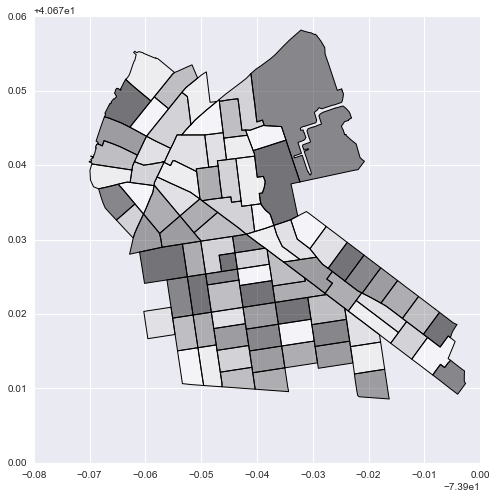

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

# quick plot of the study area
fig, ax = plt.subplots(figsize=(8,8))
ct_bk.plot(ax=ax)

In [9]:
# create new column containing tract polygon centroids, to use as approximate trip origins (lat/lon)
ct_bk['centroid'] = ct_bk.geometry.centroid
ct_bk.head()

/Users/ianstuart/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


,boro_code,boro_ct_2010,boro_name,cdeligibil,ct_2010,ctlabel,geometry,ntacode,ntaname,puma,shape_area,shape_leng,centroid
88,3,3024500,Brooklyn,E,024500,245,(POLYGON ((-73.9495568871113 40.68039040292329...,BK75,Bedford,4003,1795931.61813,5582.2225628,POINT (-73.95190111786707 40.68288056187263)
92,3,3024900,Brooklyn,E,024900,249,(POLYGON ((-73.94716450741116 40.6851123909669...,BK75,Bedford,4003,1813352.67282,5777.65519333,POINT (-73.94839043315831 40.68298334654183)
100,3,3026300,Brooklyn,E,026300,263,(POLYGON ((-73.9420768492443 40.68869720248089...,BK75,Bedford,4003,1287405.97132,4799.55684944,POINT (-73.94513173668624 40.68946843761689)
103,3,3026700,Brooklyn,I,026700,267,(POLYGON ((-73.94134827184915 40.6850312025125...,BK75,Bedford,4003,1717367.87727,5340.2440655,POINT (-73.94403810977437 40.68397283844256)
105,3,3026900,Brooklyn,E,026900,269,(POLYGON ((-73.94076893329961 40.6821008390388...,BK75,Bedford,4003,1441848.77189,5051.01893209,POINT (-73.9433171581364 40.68128262699694)


In [10]:
# get longitude coordinate of the first entry
ct_bk.centroid.iloc[0].x

-73.95190111786707

### Get census tract centroids for Manhattan (destination tracts)

In [11]:
# create new dataframe with all MN census tracts
ct_mn = ct[ct.boro_name == 'Manhattan']
print "Total census tracts in Manhattan: " + str(len(ct_mn))

Total census tracts in Manhattan: 288


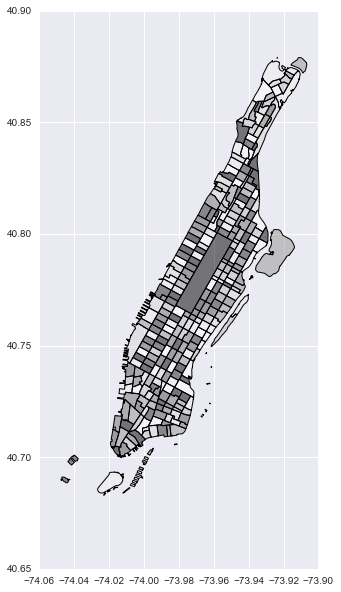

In [12]:
# quick plot of MN tracts
fig, ax = plt.subplots(figsize=(5,10))
ct_mn.plot(ax=ax, )

In [13]:
# create a centroid column
ct_mn['centroid'] = ct.geometry.centroid

/Users/ianstuart/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


### Test api request using first entry from BK and MN data as origin and destination

In [14]:
# set origin and destination coordinate variables
orig_lat = ct_bk.centroid.iloc[0].y
orig_lon = ct_bk.centroid.iloc[0].x
dest_lat = ct_mn.centroid.iloc[1].y
dest_lon = ct_mn.centroid.iloc[1].x

payload = {
    'locations': [
        {'lat':orig_lat,'lon':orig_lon}, 
        {'lat':dest_lat,'lon':dest_lon}
    ],
    'costing': 'multimodal',
}

api_key = {'api_key': 'mapzen-a75iBa1'}

r = requests.get('https://valhalla.mapzen.com/route', json=payload, params=api_key)
print r.url
r.json()

https://valhalla.mapzen.com/route?api_key=mapzen-a75iBa1


{u'trip': {u'language': u'en-US',
  u'legs': [{u'maneuvers': [{u'begin_shape_index': 0,
      u'end_shape_index': 1,
      u'instruction': u'Walk east on Jefferson Avenue.',
      u'length': 0.152,
      u'street_names': [u'Jefferson Avenue'],
      u'time': 107,
      u'travel_mode': u'pedestrian',
      u'travel_type': u'foot',
      u'type': 2,
      u'verbal_pre_transition_instruction': u'Walk east on Jefferson Avenue for 200 meters.'},
     {u'begin_shape_index': 1,
      u'end_shape_index': 5,
      u'instruction': u'Turn right onto Nostrand Avenue.',
      u'length': 0.324,
      u'street_names': [u'Nostrand Avenue'],
      u'time': 229,
      u'travel_mode': u'pedestrian',
      u'travel_type': u'foot',
      u'type': 10,
      u'verbal_post_transition_instruction': u'Continue for 300 meters.',
      u'verbal_pre_transition_instruction': u'Turn right onto Nostrand Avenue.',
      u'verbal_transition_alert_instruction': u'Turn right onto Nostrand Avenue.'},
     {u'begin_shape_i

In [15]:
#### route shape decoding function (https://mapzen.com/documentation/mobility/decoding/)

import sys

# six degrees of precision in valhalla
inv = 1.0 / 1e6;

# decode an encoded string
def decode(encoded):
  decoded = []
  previous = [0,0]
  i = 0
  #for each byte
  while i < len(encoded):
    #for each coord (lat, lon)
    ll = [0,0]
    for j in [0, 1]:
      shift = 0
      byte = 0x20
      #keep decoding bytes until you have this coord
      while byte >= 0x20:
        byte = ord(encoded[i]) - 63
        i += 1
        ll[j] |= (byte & 0x1f) << shift
        shift += 5
      #get the final value adding the previous offset and remember it for the next
      ll[j] = previous[j] + (~(ll[j] >> 1) if ll[j] & 1 else (ll[j] >> 1))
      previous[j] = ll[j]
    #scale by the precision and chop off long coords also flip the positions so
    #its the far more standard lon,lat instead of lat,lon
    decoded.append([float('%.6f' % (ll[1] * inv)), float('%.6f' % (ll[0] * inv))])
  #hand back the list of coordinates
  return decoded

In [16]:
import json
import shapely as sh

response = r.json()
# access the encoded route geometry in the json/dictionary response
route_shape_encoded = response['trip']['legs'][0]['shape']

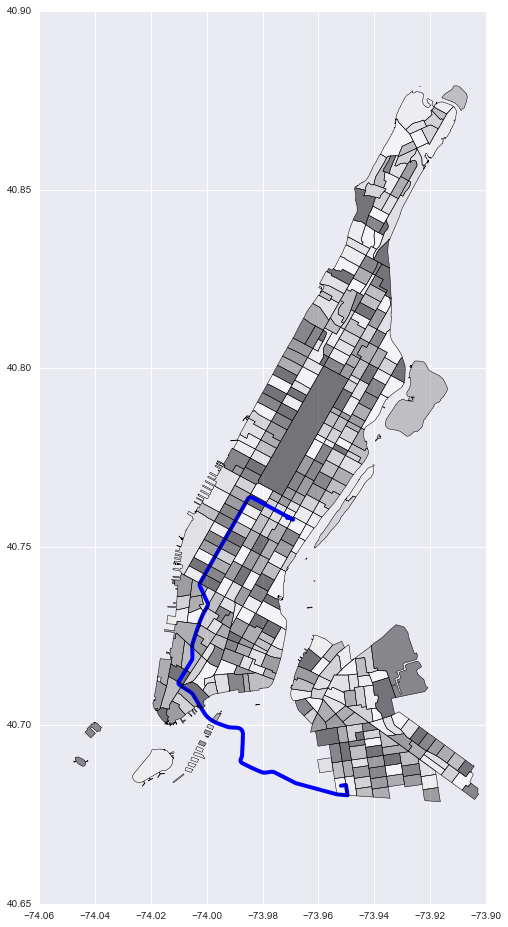

In [17]:
# decode the route shape from the json response
route_shape = decode(route_shape_encoded)

# convert list of lat/lon pairs into shapely point objects
points = [sh.geometry.Point(x) for x in route_shape]
# print points

# convert the points into a shapely linestring object
route_linestring = sh.geometry.LineString(points)
x, y = route_linestring.xy
# print x, y

# plot the linestring
fig, ax = plt.subplots(figsize=(8,16))
ax.plot(x, y, color='b',
    linewidth=4, solid_capstyle='round')
ct_mn.plot(ax=ax, linewidth=0.5)
ct_bk.plot(ax=ax, linewidth=0.5)

In [18]:
#### Check crs information?

### Test automated requests using one Brooklyn census tract and first 10 Manhattan census tracts (one to many)

In [20]:
# use ratelimiter package to stay within mapzen api limits (max 2 calls per second)
from ratelimiter import RateLimiter

rate_limiter = RateLimiter(max_calls=1, period=1)

In [22]:
# set origin coordinate variables
orig_lat = ct_bk.centroid.iloc[0].y
orig_lon = ct_bk.centroid.iloc[0].x

api_key = {'api_key': 'mapzen-a75iBa1'}

# empty array to store travel times
times = []

# function to get api responses using destination tract centroid as the parameter
def get_responses(dest_centroid):
    
    dest_lat = dest_centroid.y
    dest_lon = dest_centroid.x    
    
    payload = {
        'locations': [
            {'lat':orig_lat,'lon':orig_lon}, 
            {'lat':dest_lat,'lon':dest_lon}
        ],
        'costing': 'multimodal',
    }

    r = requests.get('https://valhalla.mapzen.com/route', json=payload, params=api_key)
    response = r.json()
    time = response['trip']['summary']['time']
    times.append(time)

# call the function for two destination tracts, once per second, to stay within api limit    
for i in np.arange(0, 10, 2):
    with rate_limiter:
        ct_mn.centroid[i:i+2].apply(get_responses)

In [23]:
print "Travel times in seconds to first ten Manhattan census tracts:\n", times

Travel times in seconds to first ten Manhattan census tracts:
[3334, 3281, 3193, 3151, 2505, 2816, 3696, 3263, 3311, 3331]


In [24]:
# convert times from seconds to minutes
times_min = np.asarray(times)/60
print "Travel times in minutes:", times_min

Travel times in minutes: [55 54 53 52 41 46 61 54 55 55]


In [25]:
ct_mn['times'] = np.nan
ct_mn.times[:10] = times_min

/Users/ianstuart/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Users/ianstuart/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/Users/ianstuart/anaconda/lib/python2.7/site-packages/pandas/core/series.py:749: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-vers

In [26]:
ct_mn.head()

,boro_code,boro_ct_2010,boro_name,cdeligibil,ct_2010,ctlabel,geometry,ntacode,ntaname,puma,shape_area,shape_leng,centroid,times
2,1,1009800,Manhattan,I,009800,98,(POLYGON ((-73.96432543478758 40.7563815309909...,MN19,Turtle Bay-East Midtown,3808,1906016.35002,5534.19981063,POINT (-73.9677747247446 40.75578800678499),55.0
3,1,1010000,Manhattan,I,010000,100,(POLYGON ((-73.96802436915851 40.7595781400528...,MN19,Turtle Bay-East Midtown,3808,1860938.37721,5692.16873705,POINT (-73.97123160585845 40.75806566605351),54.0
4,1,1010200,Manhattan,I,010200,102,(POLYGON ((-73.97124277307127 40.7609364184790...,MN17,Midtown-Midtown South,3807,1860992.70485,5687.80243866,POINT (-73.97444936939443 40.75942376908788),53.0
5,1,1010400,Manhattan,I,010400,104,(POLYGON ((-73.97445730550224 40.7622930835248...,MN17,Midtown-Midtown South,3807,1864600.41684,5693.03636727,POINT (-73.97767288517021 40.76077898600464),52.0
6,1,1011300,Manhattan,I,011300,113,(POLYGON ((-73.98411754823195 40.7548420534646...,MN17,Midtown-Midtown South,3807,1890907.29102,5699.8606412,POINT (-73.9878699355351 40.75477510309067),41.0


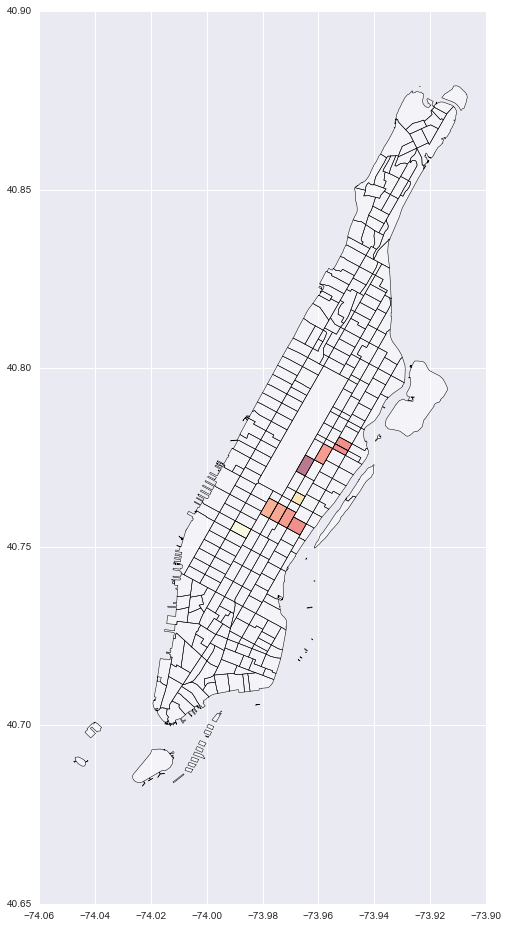

In [27]:
# plot sample destination census tracts colored by travel time

fig, ax = plt.subplots(figsize=(8,16))
ct_mn.plot(ax=ax, color='w', linewidth=0.5)
ct_mn[:10].plot(ax=ax, linewidth=0.5, column='times', cmap='YlOrRd')
# ct_bk.plot(ax=ax, linewidth=0.5)

### Test automated requests using one Brooklyn census tract and 10 random Manhattan census tracts
#### Get fastest route with and without the L
#### Save the time difference and route shape in the BK dataframe

In [78]:
orig_dest = gp.GeoDataFrame(
    columns=['time', 'time_alt', 
             'time_diff', 'percent_change', 'route', 'route_alt'])

orig_dest.head()

# routes_bk = ct_bk
# routes_bk['time'] = np.nan
# routes_bk['time_alt'] = np.nan
# routes_bk['time_diff'] = np.nan
# routes_bk['percent_change'] = np.nan
# routes_bk['route'] = np.nan
# routes_bk['route_alt'] = np.nan

,time,time_alt,time_diff,percent_change,route,route_alt


In [79]:
# set origin coordinate variables
orig_lat = ct_bk.centroid.iloc[20].y
orig_lon = ct_bk.centroid.iloc[20].x

# function to get api responses using destination tract centroid as the parameter
# saves difference in travel time with and without the L (positive value means increase in travel time)
# adds each time, the absolute change, the percentage change, and the alternate route shapes to the 'routes_bk' df 
def get_responses(dest_centroid):
    
    dest_lat = dest_centroid.y
    dest_lon = dest_centroid.x    
    
    payload = {
        'locations': [
            {'lat':orig_lat,'lon':orig_lon}, 
            {'lat':dest_lat,'lon':dest_lon}
        ],
        'costing': 'multimodal',
    }

    payload_alt = {
        'locations': [
            {'lat':orig_lat,'lon':orig_lon}, 
            {'lat':dest_lat,'lon':dest_lon}
        ],
        'costing': 'multimodal',
        'costing_options': {
            "transit": {
                "filters": {
                    "stops": {
                        "ids": [
                            "s-dr5rswb4zp-1av<l06n",
                            "s-dr5rsrhyn3-3av<l05n",
                            "s-dr5rsr9975-unionsq~14st<l03n",
                            "s-dr5ru0j0jv-6av<l02n",
                            "s-dr5ru02yqu-8av<l01n"
                        ],
                        "action":"exclude"
                    }
                }
            }
        }
    }
    
    r = requests.get('https://valhalla.mapzen.com/route', json=payload, params=api_key)
    r_alt = requests.get('https://valhalla.mapzen.com/route', json=payload_alt, params=api_key)

    response = r.json()
    response_alt = r_alt.json()
    time = response['trip']['summary']['time']
    time_alt = response_alt['trip']['summary']['time']
    time_diff = time_alt - time
    percent_change = time_diff/time
    route_encoded = response['trip']['legs'][0]['shape']
    route_alt_encoded = response_alt['trip']['legs'][0]['shape']
    
    orig_dest.time = time
    orig_dest.time_alt = time_alt
    orig_dest.time_diff = time_diff
    orig_dest.percent_change = percent_change
    orig_dest.route = route_encoded
    orig_dest.route_alt = route_alt_encoded
    
#     result = {
#         'time':time, 
#         'time_alt':time_alt, 
#         'time_diff':time_diff, 
#         'percent_change':percent_change, 
#         'route':route_encoded, 
#         'route_alt':route_alt_encoded
#     }
    result = [time, time_alt, time_diff, percent_change, route_encoded, route_alt_encoded]
    return result
    
# set seed for random selection of MN tracts
np.random.seed(0)

# call the function for once per second (two separate requests from api), to stay within api limit
# choose 5 random MN destination tracts
for i in range(2):
    # 288 tracts in Manhattan
    j = np.random.randint(0, 288)
    with rate_limiter:
        data = ct_mn.centroid[j:j+1].apply(get_responses)
    orig_dest = orig_dest.append(data, ignore_index=True)

172
47
117
192
251


In [80]:
orig_dest.head()

,time,time_alt,time_diff,percent_change,route,route_alt,1730,842,1246,1783,2109
0,2719.0,3379.0,660.0,0.0,}_{slAvnk`lCab@vDkk@bF_m@rFhHnfB?fw@F??NOpp@?v...,}_{slAvnk`lCab@vDvH~eBbLxhCiWfC?^ocVsGkbLjeEO?...,"[2925, 3955, 1030, 0, }_{slAvnk`lCab@vDkk@bF_m...",NaN,NaN,NaN,NaN
1,2719.0,3379.0,660.0,0.0,}_{slAvnk`lCab@vDkk@bF_m@rFhHnfB?fw@F??NOpp@?v...,}_{slAvnk`lCab@vDvH~eBbLxhCiWfC?^ocVsGkbLjeEO?...,NaN,"[2179, 2179, 0, 0, }_{slAvnk`lC`Hm@fm@sFvH~eBb...",NaN,NaN,NaN
2,2719.0,3379.0,660.0,0.0,}_{slAvnk`lCab@vDkk@bF_m@rFhHnfB?fw@F??NOpp@?v...,}_{slAvnk`lCab@vDvH~eBbLxhCiWfC?^ocVsGkbLjeEO?...,NaN,NaN,"[2501, 2501, 0, 0, }_{slAvnk`lCab@vDvH~eBbLxhC...",NaN,NaN
3,2719.0,3379.0,660.0,0.0,}_{slAvnk`lCab@vDkk@bF_m@rFhHnfB?fw@F??NOpp@?v...,}_{slAvnk`lCab@vDvH~eBbLxhCiWfC?^ocVsGkbLjeEO?...,NaN,NaN,NaN,"[1706, 3117, 1411, 0, }_{slAvnk`lCab@vDkk@bF_m...",NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[2719, 3379, 660, 0, }_{slAvnk`lCab@vDkk@bF_m@..."
